# US Sales Tax Analysis
In this project, we will analyse the sales tax of US states and territories.
For each state, we consider the state level tax as well as localities level taxes.
We define:
1. State Tax: The sales tax rate applied for each sale in the state
2. Local Tax: The sum of sales tax rate applied for each sale that are imposed by Counties, Cities and Districts
3. Tax Level: The number of different sales tax applied for a sale in a state, e.g. if a state has only state level tax, then the tax level for that state is considered to be 1, and if in a state, there is a location where there is application of state tax as well as county tax, that state is considered to have tax level 2, and so on...

Inside a state, the local tax for each locality is the sum of the rates that are applied at each tax level.
The overall local tax rate of the state is the average of the local rates for all the localities inside the state

In [31]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


### Data Source


In [32]:
# Create a folder to save files
output=os.path.join('Images')
if not os.path.exists(output):
    os.mkdir(output)
    
input_files = os.path.join('Resources','*.csv')
df_data=pd.concat(map(pd.read_csv, glob.glob(input_files)))
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40900 entries, 0 to 192
Data columns (total 9 columns):
State                    40900 non-null object
ZipCode                  40900 non-null int64
TaxRegionName            40900 non-null object
StateRate                40900 non-null float64
EstimatedCombinedRate    40900 non-null float64
EstimatedCountyRate      40900 non-null float64
EstimatedCityRate        40900 non-null float64
EstimatedSpecialRate     40900 non-null float64
RiskLevel                40900 non-null int64
dtypes: float64(5), int64(2), object(2)
memory usage: 3.1+ MB


### ZipCode Normalization

In [33]:
df_data["ZipCode"]= df_data["ZipCode"].astype('str')
df_data["ZipCode"] = df_data["ZipCode"].str.pad(5, side ='left', fillchar ='0')

### Adding State names
In the data, the state names are shown with the 2 letter abbreviation, we will use the State names in the dictionary below to add the names

In [34]:
states = [{'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}]
states
df_states= pd.DataFrame(states).T

df_states.reset_index(inplace=True)
df_states.rename(columns={0:"State Name","index":"State"},inplace=True)
df_data=df_data.merge(df_states,how="inner", on = "State")
df_data.head()

,State,ZipCode,TaxRegionName,StateRate,EstimatedCombinedRate,EstimatedCountyRate,EstimatedCityRate,EstimatedSpecialRate,RiskLevel,State Name
0,AK,99501,ALASKA STATE,0.0,0.0,0.0,0.0,0.0,1,Alaska
1,AK,99502,ALASKA STATE,0.0,0.0,0.0,0.0,0.0,1,Alaska
2,AK,99503,ALASKA STATE,0.0,0.0,0.0,0.0,0.0,1,Alaska
3,AK,99504,ALASKA STATE,0.0,0.0,0.0,0.0,0.0,1,Alaska
4,AK,99505,ALASKA STATE,0.0,0.0,0.0,0.0,0.0,1,Alaska


### Adding the tax level for each locality
The State tax level will be the maximum of all the tax levels for the localities in the state

In [35]:
df_data["Local Taxes"]=df_data["EstimatedCountyRate"] + df_data["EstimatedCityRate"] + df_data["EstimatedSpecialRate"]

def tax_level(row):
    columns = ["StateRate", "EstimatedCountyRate", "EstimatedCityRate", "EstimatedSpecialRate"]
    return len([column for column in columns if row[column]>0])

df_data["Tax Level"] = df_data.apply(tax_level, axis = 1)
df_data.tail()

,State,ZipCode,TaxRegionName,StateRate,EstimatedCombinedRate,EstimatedCountyRate,EstimatedCityRate,EstimatedSpecialRate,RiskLevel,State Name,Local Taxes,Tax Level
40895,WY,83124,ROCK SPRINGS,0.04,0.05,0.01,0.0,0.0,1,Wyoming,0.01,2
40896,WY,83126,LINCOLN COUNTY,0.04,0.05,0.01,0.0,0.0,1,Wyoming,0.01,2
40897,WY,83127,STAR VALLEY RANCH,0.04,0.05,0.01,0.0,0.0,2,Wyoming,0.01,2
40898,WY,83128,LINCOLN COUNTY,0.04,0.05,0.01,0.0,0.0,1,Wyoming,0.01,2
40899,WY,83414,ALTA,0.04,0.06,0.02,0.0,0.0,1,Wyoming,0.02,2


## State Level Tax

In [58]:
grp_by_state = df_data.groupby(["State","State Name"])

df_state_tax = grp_by_state[["StateRate"]].mean()
df_state_tax

,,StateRate
State,State Name,
AK,Alaska,0.000000
AL,Alabama,0.040000
AR,Arkansas,0.065000
AZ,Arizona,0.056000
CA,California,0.060000
CO,Colorado,0.029000
CT,Connecticut,0.063500
DC,District of Columbia,0.060000
DE,Delaware,0.000000


# States with no state sales tax


In [37]:
# df_state_tax["Has State Tax"] = df_state_tax.apply(lambda x: True if x["StateRate"]==0.0 else False,axis=1)
df_state_tax["Has State Tax"] = df_state_tax["StateRate"]!=0.0 

df_state_tax[df_state_tax["Has State Tax"]==False][[]]

,
State,State Name
AK,Alaska
DE,Delaware
MT,Montana
NH,New Hampshire
OR,Oregon


# States with state sales tax

In [38]:
df_state_tax[df_state_tax["Has State Tax"]==True][["StateRate"]]


,,StateRate
State,State Name,
AL,Alabama,0.040000
AR,Arkansas,0.065000
AZ,Arizona,0.056000
CA,California,0.060000
CO,Colorado,0.029000
CT,Connecticut,0.063500
DC,District of Columbia,0.060000
FL,Florida,0.060000
GA,Georgia,0.040000


# Pie Chart


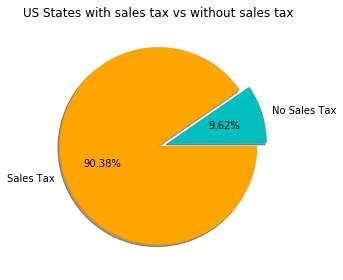

In [51]:
df_cnt = df_state_tax.groupby("Has State Tax").count()
df_cnt
plt.pie(df_cnt["StateRate"],labels=["No Sales Tax","Sales Tax"]  ,colors=['c','orange'] ,explode=[0.1,0],shadow=True,
       autopct="%1.2f%%")
plt.title("US States with sales tax vs without sales tax")
plt.tight_layout()
plt.savefig(os.path.join(output,"statetax_pie.png"))
plt.show()


## Local Taxes

In [40]:
df_local_tax = grp_by_state[["Local Taxes"]].mean()
df_local_tax

,,Local Taxes
State,State Name,
AK,Alaska,0.018930
AL,Alabama,0.040218
AR,Arkansas,0.021232
AZ,Arizona,0.023141
CA,California,0.023012
CO,Colorado,0.032664
CT,Connecticut,0.000000
DC,District of Columbia,0.000000
DE,Delaware,0.000000


# States with no Local Taxes

In [60]:
df_local_tax["Has Local Tax"] = df_local_tax["Local Taxes"]!=0.0 

df_local_tax[df_local_tax["Has Local Tax"]==False][[]]

,
State,State Name
CT,Connecticut
DC,District of Columbia
DE,Delaware
IN,Indiana
KY,Kentucky
MA,Massachusetts
MD,Maryland
ME,Maine
MI,Michigan


# States with local taxes

In [42]:

df_local_tax[df_local_tax["Has Local Tax"]==True][["Local Taxes"]]

,,Local Taxes
State,State Name,
AK,Alaska,0.018930
AL,Alabama,0.040218
AR,Arkansas,0.021232
AZ,Arizona,0.023141
CA,California,0.023012
CO,Colorado,0.032664
FL,Florida,0.008291
GA,Georgia,0.034522
HI,Hawaii,0.002518


### Pie Chart

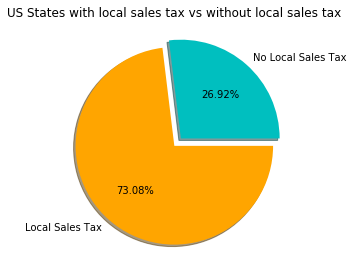

In [52]:
df_local = df_local_tax.groupby("Has Local Tax").count()
#df_local
plt.pie(df_local["Local Taxes"],labels=["No Local Sales Tax","Local Sales Tax"]  ,colors=['c','orange'] ,explode=[0.1,0],shadow=True,
       autopct="%1.2f%%")
plt.title("US States with local sales tax vs without local sales tax")
plt.tight_layout()
plt.savefig(os.path.join(output,"localtax_pie.png"))
plt.show()

## Total Taxes

### Top 5 States that have higher overall sales taxes

In [44]:
df_total_tax = grp_by_state[["EstimatedCombinedRate"]].mean()
df_total_tax.nlargest(5,"EstimatedCombinedRate")

,,EstimatedCombinedRate
State,State Name,
PR,Puerto Rico,0.114659
TN,Tennessee,0.094904
LA,Louisiana,0.091396
WA,Washington,0.086900
AR,Arkansas,0.086232


### Top 5 States that have lower overall sales taxes

In [45]:
df_total_tax.nsmallest(5, "EstimatedCombinedRate")

,,EstimatedCombinedRate
State,State Name,
DE,Delaware,0.00000
MT,Montana,0.00000
NH,New Hampshire,0.00000
OR,Oregon,0.00000
AK,Alaska,0.01893


## Overall Taxes Analysis

### Bubble Plot of Taxes in each State

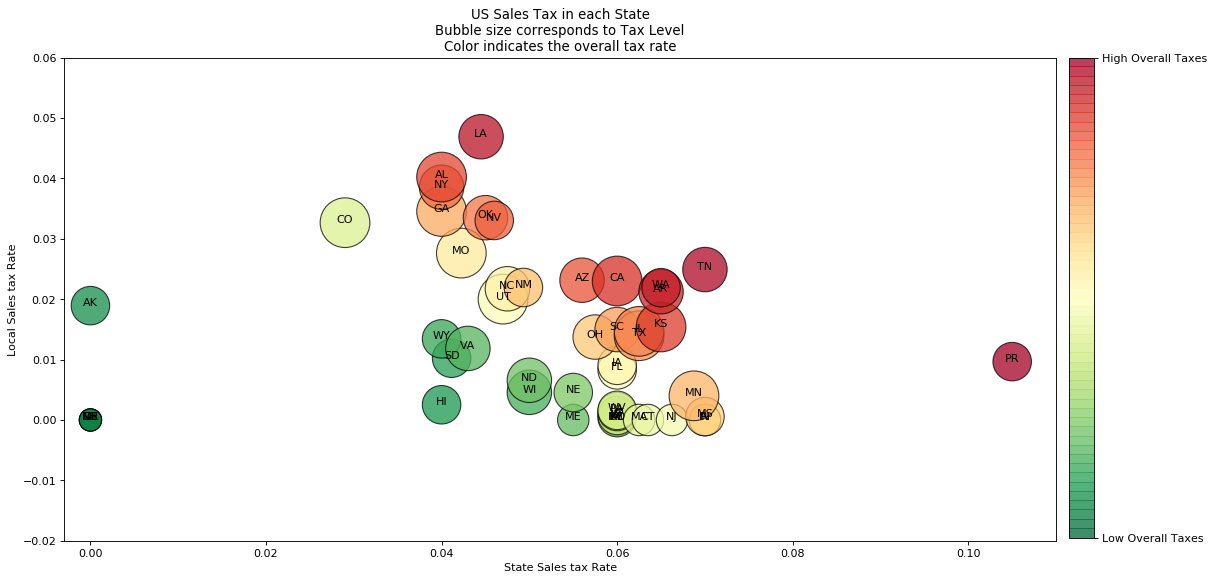

In [53]:
from matplotlib import colorbar

All_Taxes = pd.DataFrame(grp_by_state["StateRate", "EstimatedCombinedRate", "Local Taxes"].mean())
All_Taxes["Tax Level"] = grp_by_state["Tax Level"].max()
All_Taxes = All_Taxes.reset_index()
All_Taxes = All_Taxes.set_index("State")
All_Taxes = All_Taxes.sort_values("EstimatedCombinedRate")

cmap = plt.cm.get_cmap('RdYlGn', 52)
#cmap = plt.colors.ListedColormap(cmap.colors[::-1])
All_Taxes["colors"] = [cmap(51-i) for i in range(cmap.N)]

fig = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(All_Taxes["StateRate"], All_Taxes["Local Taxes"], marker = "o",
                c = All_Taxes["colors"], edgecolors="k", s=400*(All_Taxes["Tax Level"]+1),
                alpha=.75)#, label = f"{level}")
for i, txt in enumerate(All_Taxes.index):
    plt.annotate(txt, [All_Taxes["StateRate"][i], All_Taxes["Local Taxes"][i]], ha='center')

plt.xlim(-0.003,0.11)
plt.ylim(-0.02,0.06)
plt.xlabel("State Sales tax Rate")
plt.ylabel("Local Sales tax Rate")
#plt.legend(title = "Tax Levels", ncol=5, mode="expand", facecolor="None", bbox_to_anchor = (.6,.6,.4,.4))
#lgnd.legendHandles[0].
plt.title("US Sales Tax in each State\nBubble size corresponds to Tax Level\nColor indicates the overall tax rate")
ax = fig.add_axes([0.91, 0.13, 0.02, 0.75])
cb = colorbar.ColorbarBase(ax, cmap=cmap, spacing='proportional', ticks = [0,1], alpha = .75)
cb.ax.set_yticklabels(['High Overall Taxes', 'Low Overall Taxes'])
cb.ax.invert_yaxis()
plt.savefig(os.path.join(output,"overalltax_bubble.png"))
plt.show()

### Analysis:
From the bubble plot, We can see that states with high taxes have high state taxes and also have local taxes, i.e. they have more than 1 level of tax applied. 
Let's now analyse the effect of the tax level on State and overall tax rate.

## Tax Level Distribution

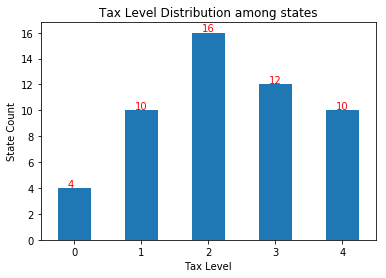

In [54]:
tax_levelg = All_Taxes.groupby("Tax Level")

tax_level_df = tax_levelg[["State Name"]].count()
xsis = tax_level_df.plot.bar(rot = 0, legend = False, title = "Tax Level Distribution among states")
plt.ylabel("State Count")
for val in range(0,5):
    xsis.annotate(s=f'{tax_level_df["State Name"][val]:.0f}',xy=(val-0.1,tax_level_df["State Name"][val]+0.1),color='r')
plt.savefig(os.path.join(output,"taxlevel_bar.png"))
plt.show()


## State Tax rate dependency with Tax Level

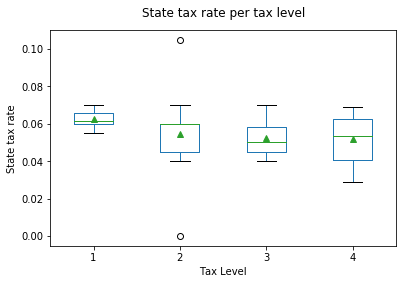

In [55]:
axes = All_Taxes[All_Taxes["Tax Level"]>0].boxplot(column='StateRate', by='Tax Level', showfliers = True, showmeans =True, grid = False)
fig = axes.get_figure()
fig.suptitle("State tax rate per tax level")
plt.title("")
plt.ylabel("State tax rate")
plt.savefig(os.path.join(output,"statetax_box.png"))
plt.show()

### Analysis:
From the bax-plot, States have higher taxes when the state tax is the only applied tax. When a local tax is imposed, we can notice that the state tax is decreased in general; however, it seems to not decrease futhur as more local tax levels get added. This will lead to overall tax increase if more than 1 local taxes get applied. Let's analyse the overall taxes to confirm

## Overall Tax rate dependency with Tax Level

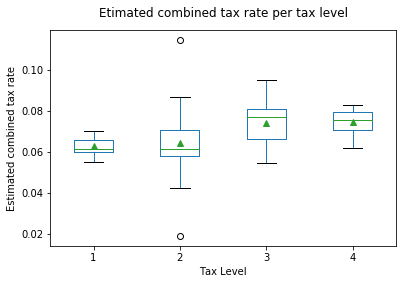

In [56]:
axes = All_Taxes[All_Taxes["Tax Level"]>0].boxplot(column='EstimatedCombinedRate', by='Tax Level', showfliers = True, showmeans =True, grid = False)
fig = axes.get_figure()
fig.suptitle("Etimated combined tax rate per tax level")
plt.title("")
plt.ylabel("Estimated combined tax rate")
plt.savefig(os.path.join(output,"overalltax_box.png"))
plt.show()

### Analysis:
In conformity with the previous analysis, we can see that there seem to not be any difference between states with just state level tax and state with state level and one local level tax. However, we see an increase in tax rate for states with more than 1 level local tax